In [1]:
import torch

In [2]:
print(torch.__version__)

2.0.1+cu117


In [3]:
import torch
print(torch.version.cuda)  # CUDA version PyTorch was built with
print(torch.cuda.is_available())  # Check if CUDA is available


11.7
True


In [4]:
# Importing necessary libraries
import torch
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
from models import DiT  # Assuming models.py contains the DiT implementation
from diffusion import create_diffusion
# from torch.nn.parallel import DistributedDataParallel as DDP # can only be used when multiple GPUs are available
from copy import deepcopy
from collections import OrderedDict
from tqdm.notebook import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
batch_size = 4 # 16 ?
epochs = 5
learning_rate = 1e-4

# Custom transformation to add an extra channel
class AddAlphaChannel(object):
    def __call__(self, img):
        # Add a new channel (e.g., copy of the red channel or noise)
        img = torch.cat([img, img[0:1, :, :]], dim=0)  # Adding a copy of the first channel (RGB -> RGBA)
        return img

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    #AddAlphaChannel(),  # Add the extra channel
    #transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5))  # Normalize 4 channels
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize 3 channels
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [5]:
subset_size = int(len(train_dataset) * 0.25)

# Generate a list of random indices
indices = torch.randperm(len(train_dataset)).tolist()

# Select the first 25% of the indices
subset_indices = indices[:subset_size]

# Create a new subset of the dataset
subset_dataset = Subset(train_dataset, subset_indices)

# Create a DataLoader for the subset
train_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)

In [6]:
for i, (images, labels) in enumerate(train_loader):
    print(images.shape)
    print(labels)
    if i == 5:
        break

torch.Size([4, 3, 32, 32])
tensor([4, 7, 4, 6])
torch.Size([4, 3, 32, 32])
tensor([5, 8, 6, 8])
torch.Size([4, 3, 32, 32])
tensor([4, 6, 1, 5])
torch.Size([4, 3, 32, 32])
tensor([1, 9, 2, 2])
torch.Size([4, 3, 32, 32])
tensor([2, 2, 3, 2])
torch.Size([4, 3, 32, 32])
tensor([2, 4, 3, 2])


These labels are a 1 x B tensor where B is the batch size. Each label is an integer that ranges from 0 to 9.

In [7]:
print(len(train_loader)) # 3125 batches of size 4

3125


In [8]:
@torch.no_grad()
def update_ema(ema_model, model, decay=0.9999):
    """
    Step the EMA model towards the current model.
    """
    ema_params = OrderedDict(ema_model.named_parameters())
    model_params = OrderedDict(model.named_parameters())

    for name, param in model_params.items():
        # TODO: Consider applying only to params that require_grad to avoid small numerical changes of pos_embed
        ema_params[name].mul_(decay).add_(param.data, alpha=1 - decay)


def requires_grad(model, flag=True):
    """
    Set requires_grad flag for all parameters in a model.
    """
    for p in model.parameters():
        p.requires_grad = flag


def cleanup():
    """
    End DDP training.
    """
    dist.destroy_process_group()


def create_logger(logging_dir):
    """
    Create a logger that writes to a log file and stdout.
    """
    if dist.get_rank() == 0:  # real logger
        logging.basicConfig(
            level=logging.INFO,
            format='[\033[34m%(asctime)s\033[0m] %(message)s',
            datefmt='%Y-%m-%d %H:%M:%S',
            handlers=[logging.StreamHandler(), logging.FileHandler(f"{logging_dir}/log.txt")]
        )
        logger = logging.getLogger(__name__)
    else:  # dummy logger (does nothing)
        logger = logging.getLogger(__name__)
        logger.addHandler(logging.NullHandler())
    return logger


def center_crop_arr(pil_image, image_size):
    """
    Center cropping implementation from ADM.
    https://github.com/openai/guided-diffusion/blob/8fb3ad9197f16bbc40620447b2742e13458d2831/guided_diffusion/image_datasets.py#L126
    """
    while min(*pil_image.size) >= 2 * image_size:
        pil_image = pil_image.resize(
            tuple(x // 2 for x in pil_image.size), resample=Image.BOX
        )

    scale = image_size / min(*pil_image.size)
    pil_image = pil_image.resize(
        tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
    )

    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return Image.fromarray(arr[crop_y: crop_y + image_size, crop_x: crop_x + image_size])

In [9]:
model = DiT(input_size=32, in_channels=3, depth=12, hidden_size=384, patch_size=4, num_heads=6) # small DiT
model = model.to(device)

ema = deepcopy(model).to(device)
requires_grad(ema, False)

# model = DDP(model.to(device), device_ids=[rank])

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

diffusion = create_diffusion(timestep_respacing="")

In [10]:
epochs = 1
train_steps = 0
log_steps = 0
running_loss = 0
losses = []

In [11]:
# Training loop
for epoch in range(epochs):
    model.train()

    for i, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)

        t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],), device=device)

        model_kwargs = dict(y=y)
        loss_dict = diffusion.training_losses(model, x, t, model_kwargs)
        loss = loss_dict["loss"].mean()

        break

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #update_ema(ema, model.module)
        update_ema(ema, model)

        # Log loss values:
        losses.append(loss.item())
        running_loss += loss.item()
        log_steps += 1
        train_steps += 1

model.eval()

# Save the model
torch.save(model.state_dict(), "dit_cifar10.pth")

0it [00:00, ?it/s]

torch.Size([4, 64, 384])
tensor([ 3.2659e-01,  3.2876e-01, -5.1314e-01, -5.8167e-01,  7.7538e-02,
         4.1261e-02, -5.2873e-01, -7.2869e-02, -1.0860e+00, -8.6710e-01,
        -6.7228e-01,  1.1346e-01, -7.4606e-01, -1.2782e-01, -2.9290e-01,
        -2.3251e-01, -4.2101e-01,  1.5367e-01,  3.1654e-02,  9.9865e-02,
         3.8057e-01,  4.9915e-01,  4.7237e-01, -2.5264e-01,  3.5118e-01,
        -2.3470e-01, -8.9649e-01,  4.2755e-01, -1.3740e-01,  2.6586e-01,
         5.3159e-01, -4.5634e-01,  4.3722e-01, -2.5280e-01, -1.9763e-01,
         1.6295e-01,  3.7256e-01,  5.9755e-01, -1.0493e-01,  1.4641e-01,
        -2.8329e-01,  7.3738e-01, -8.7441e-01,  7.3340e-01, -3.1338e-01,
        -8.9843e-02, -3.4737e-01,  2.5145e-01, -8.2669e-02, -3.2587e-01,
         4.1496e-01,  8.0258e-01,  2.5291e-01,  8.7323e-01, -6.9772e-01,
        -4.0320e-01, -2.6810e-01,  2.1619e-02,  3.3660e-02, -8.4476e-02,
        -4.9327e-01,  3.4961e-01, -4.1084e-01,  6.2731e-01,  1.2510e-02,
         4.4535e-01,  2.32

After patchifying, the shape of x is (B, T, D). B = batch size, T = sequence length, and D = hidden dimension. T = (input_size/patch_size)^2. For example, T = (32/4)^2 = 64 for input size 32 and patch size 4. D tells us how long the embedding vector is. Here, it's prespecified to be 384, so one channel just contains 384 numbers. The shape of y is (B, E), where B = batch size and E = hidden dimension. Thus, a modified input would need to adhere to these dimensions.

In [12]:
print(len(losses))

0


In [13]:
print(losses[1:10], losses[1000:1010], losses[3000:3010])

[] [] []


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Create an array of floats and indexes 0 to 3125
x = np.arange(3125)  # Indexes from 0 to 3125
y = np.random.rand(3126)  # Array of random floats
print(y)

[0.16116527 0.28793052 0.43964188 ... 0.730531   0.78853008 0.8041579 ]


ValueError: x and y must have same first dimension, but have shapes (3125,) and (0,)

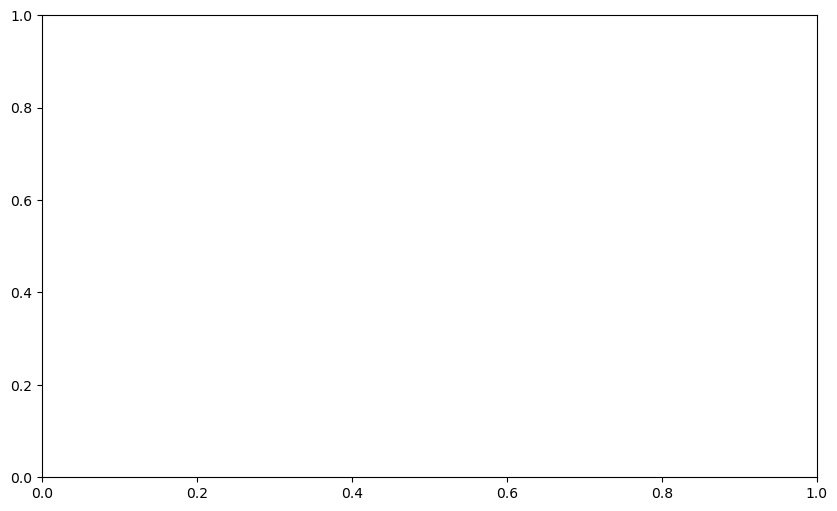

In [15]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(x, losses)
plt.title("Plot of Random Floats with Indexes 0 to 3125")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [ ]:
from torchvision.utils import save_image
# Labels to condition the model with (feel free to change):
class_labels = [207, 360, 387, 974, 88, 979, 417, 279]

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 3, 32, 32, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=1)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
#samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=4, normalize=True, value_range=(-1, 1))